In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import radTrans as rt
from scipy.interpolate import interp1d
import importlib
importlib.reload(rt)
import pandas as pd

sig [mm] =  -10.42430769135674


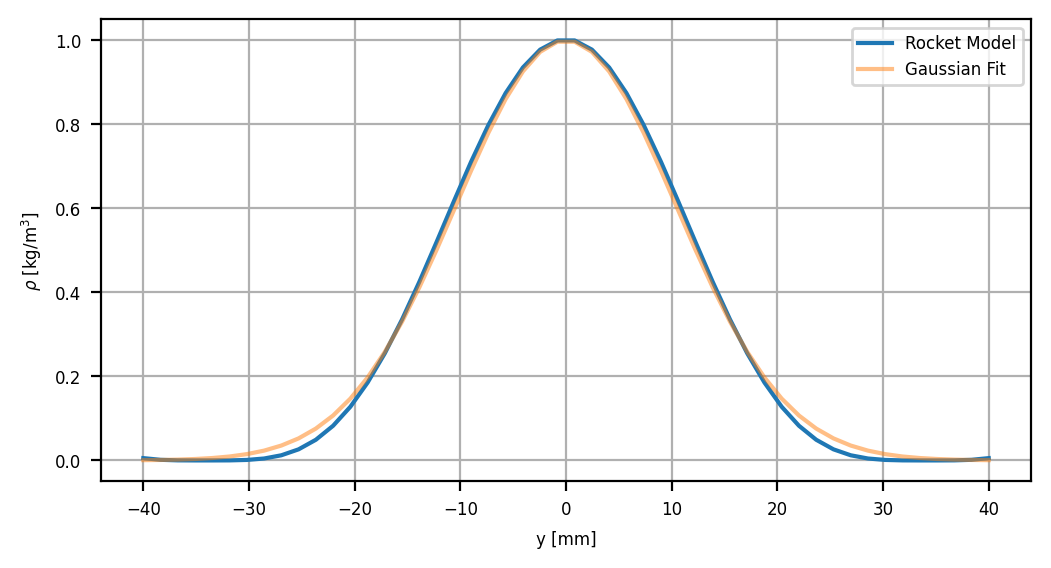

In [13]:
# Aside: determining sigma using rocket model (Not needed for this analysis since we have axial LOS)
from scipy.optimize import curve_fit

def I(t,t_rise):
    return 1e6 * np.sin(2 * np.pi * t / (4 * t_rise))**2

def gaussian(x,sig):
    return np.exp(-(x-0)**2 / (2 * sig**2))


def getDenisty(x,y,t,V,R0,t_rise):
    mu0 = 1.2566e-06
    r = np.sqrt(x**2 + y**2)
    return mu0 / (8 * np.pi**2 * R0 * r * V**2) * (I(t-(r-R0)/V,t_rise))**2
    
R0 = 20e-3 # m
V = 110e3 # m/s
x = 8e-3 + R0 # m
y = np.linspace(-40e-3,40e-3,50)
t_rise = 300e-9 # s
t = 220e-9 # s

rho = getDenisty(x,y,t,V,R0,t_rise)
rho = rho / np.max(rho) # normalize


# fit a gaussain to rho
popt, pcov = curve_fit(gaussian, y, rho)


fig, axs = plt.subplots(1,1,figsize=(6,3),dpi=200)


axs.plot(y*1e3,rho,label='Rocket Model')
axs.plot(y*1e3,gaussian(y, *popt),label='Gaussian Fit',color='tab:orange',alpha=0.5)
axs.set_xlabel('y [mm]')
axs.set_ylabel('$\\rho$ [kg/m$^3$]')
axs.grid()
axs.legend()

print('sig [mm] = ', popt[0]*1e3)


m, c =  49159.43246014513 0.000401343528568857


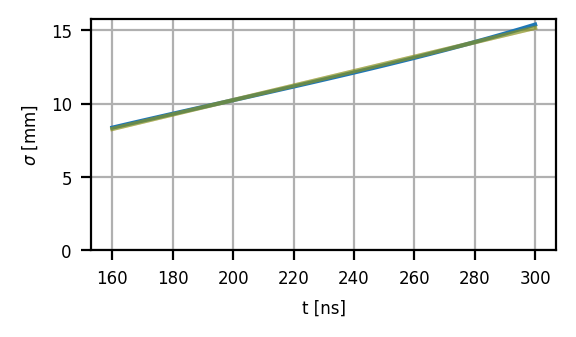

In [14]:
# do it for multiple times

# experiment properties
R0 = 20e-3 # m
V = 120e3 # m/s
x = 8e-3 + R0 # m, x-position
y = np.linspace(-40e-3,40e-3,50)
t_rise = 300e-9 # s



Tid = np.arange(160e-9,301e-9,5e-9)
sig = 0 * Tid
for ii in range(Tid.shape[0]):
    t = Tid[ii] # s
    rho = getDenisty(x,y,t,V,R0,t_rise)
    rho = rho / np.max(rho) # normalize
    # fit a gaussain to rho
    popt, pcov = curve_fit(gaussian, y, rho)
    # store sigma value
    sig[ii] = np.abs(popt[0])

    
fig, axs = plt.subplots(1,1,figsize=(3,1.5),dpi=200)
axs.plot(Tid*1e9,sig*1e3)
axs.set_ylim(ymin=0)
axs.grid()
axs.set_xlabel('t [ns]')
axs.set_ylabel('$\\sigma$ [mm]')

# linear fit

def func(x,m,c):
    return m*x + c

popt, pcov = curve_fit(func, Tid, sig)


axs.plot(Tid*1e9,func(Tid, *popt)*1e3,label='Fit',color='tab:orange',alpha=0.5)

print('m, c = ',popt[0],popt[1])
m, c = popt[0],popt[1]

def getSigma(t):
    # t [s]
    return m * t + c # sigma in [m]

axs.plot(Tid*1e9,getSigma(Tid)*1e3,color='tab:green',alpha=0.4)

# Analysis of Experimental Spectra

<b> (1) Load Experimental Data </b>

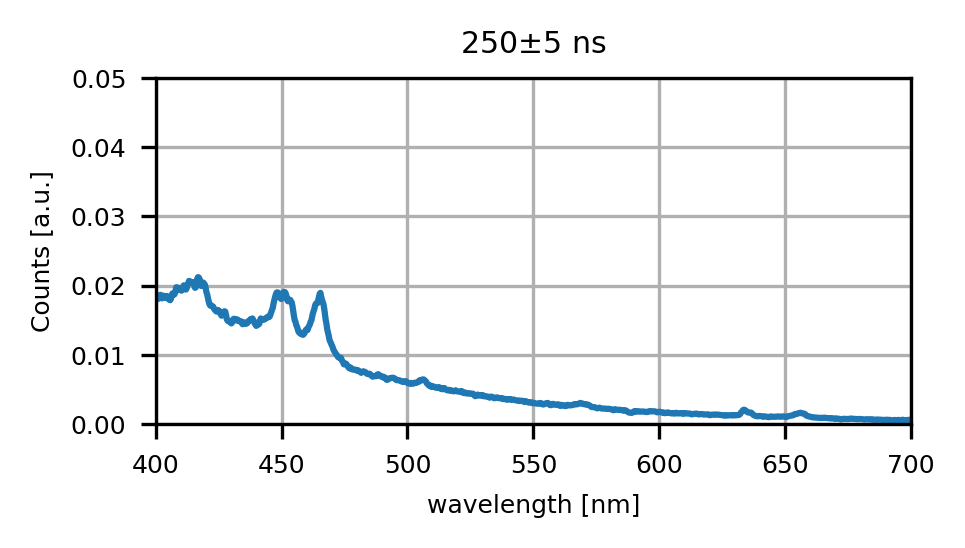

In [15]:

inDir = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/SVS/z3978/svs5/'

data = np.loadtxt(inDir + '/exp_spectra.csv',delimiter=',') # experimental data
results = pd.read_csv(inDir + 'results.csv', delimiter=',') # CSV with times and results
tid = results.iloc[:,0] # ns
delt = results.iloc[:,1] # ns

num = 2
wl = data[:,0]
Iexp = data[:,num+1]

plt.rcParams.update({'font.size': 6})
fig,axs = plt.subplots(1,1,figsize=(6.5/2,1.5),dpi=300,sharex=True,sharey=True)
axs.plot(wl,Iexp)
axs.set_xlabel('wavelength [nm]')
axs.set_ylim(ymin=0)
axs.set_ylabel('Counts [a.u.]')
axs.grid()
axs.set_xlim([400,700])
axs.set_title(str(tid.iloc[num]) + '$\pm$' + str(delt.iloc[num]) + ' ns')
axs.set_ylim([0,0.05])
plt.show()

<b> (2) Remove extra continuum </b>

This is done if a strong background continuum, for example due to reflections or other emission sources, exists in the spectrum.

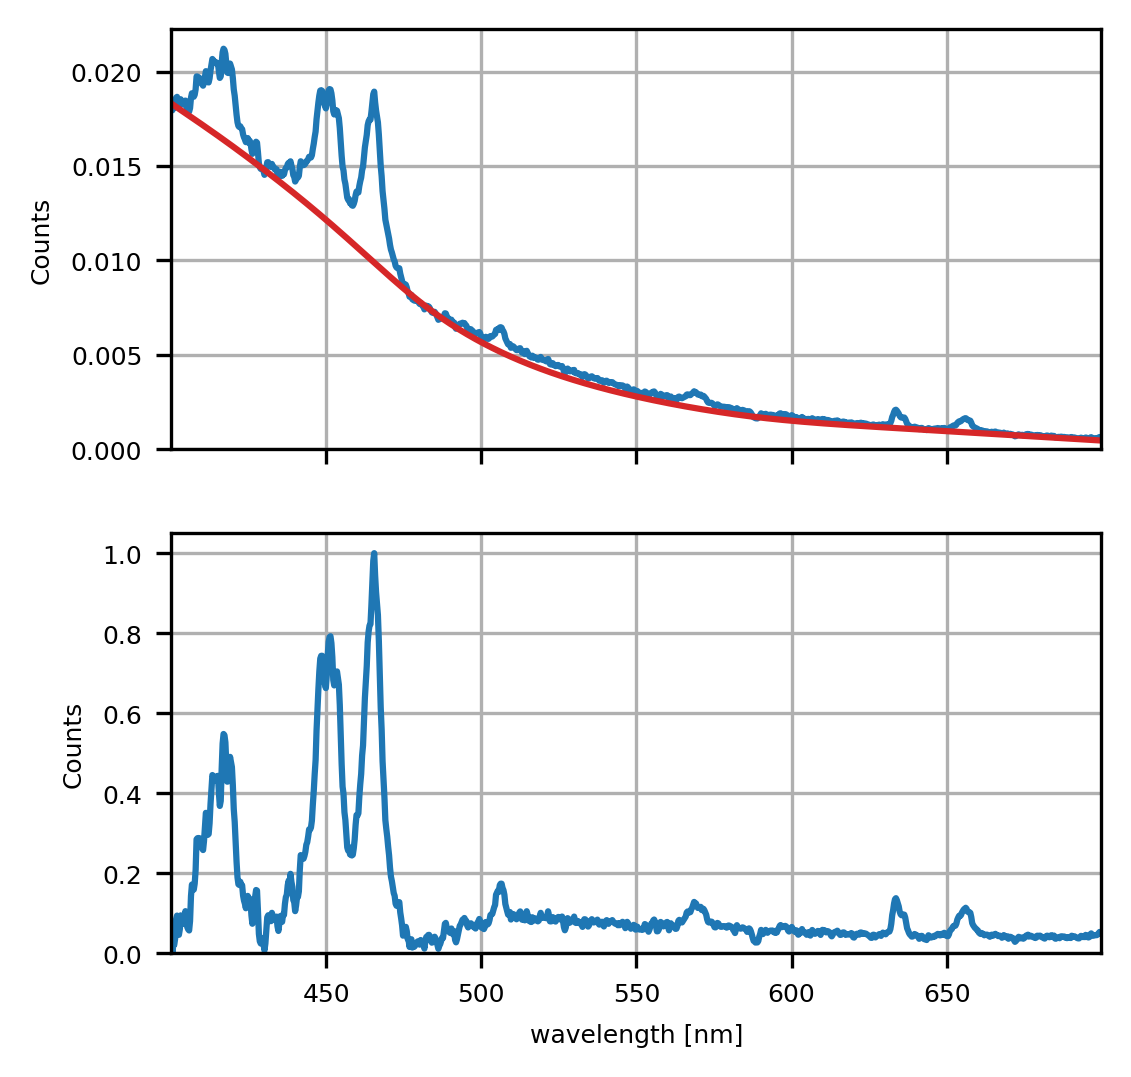

In [16]:
# Isolate so we don't include the absorption feature that complicates the continuum substraction

idx = np.argwhere((wl >= 400) & (wl <=700))
wlnew = np.squeeze(wl[idx])
Inew = np.squeeze(Iexp[idx])

# Continuum fitting

cont =  rt.baseline_als(Inew, 5e5, p=5e-3, niter=50) # find continuum

fig,axs = plt.subplots(2,1,figsize=(4,4),dpi=300,sharex=True)
axs[0].plot(wlnew,Inew)
axs[0].plot(wlnew,cont,color='tab:red')
axs[0].set_ylim(ymin=0)


Inew = Inew - cont
Inew = (Inew - Inew.min()) /  (Inew.max() - Inew.min())

axs[1].plot(wlnew,Inew,color='tab:blue')
axs[1].set_xlabel('wavelength [nm]')

    
for ii in range(axs.shape[0]):
    axs[ii].set_ylim(ymin=0)
    axs[ii].set_ylabel('Counts')
    axs[ii].grid()
    axs[ii].set_xlim([wlnew.min(),wlnew.max()])
    
plt.show()

# save the continuum substacted spectrum
arr = np.vstack([wlnew,Inew]) 
np.save(inDir + 'Exp_spectra/t=' + str(tid.iloc[num]) + '.npy',arr)

# Curve Fitting

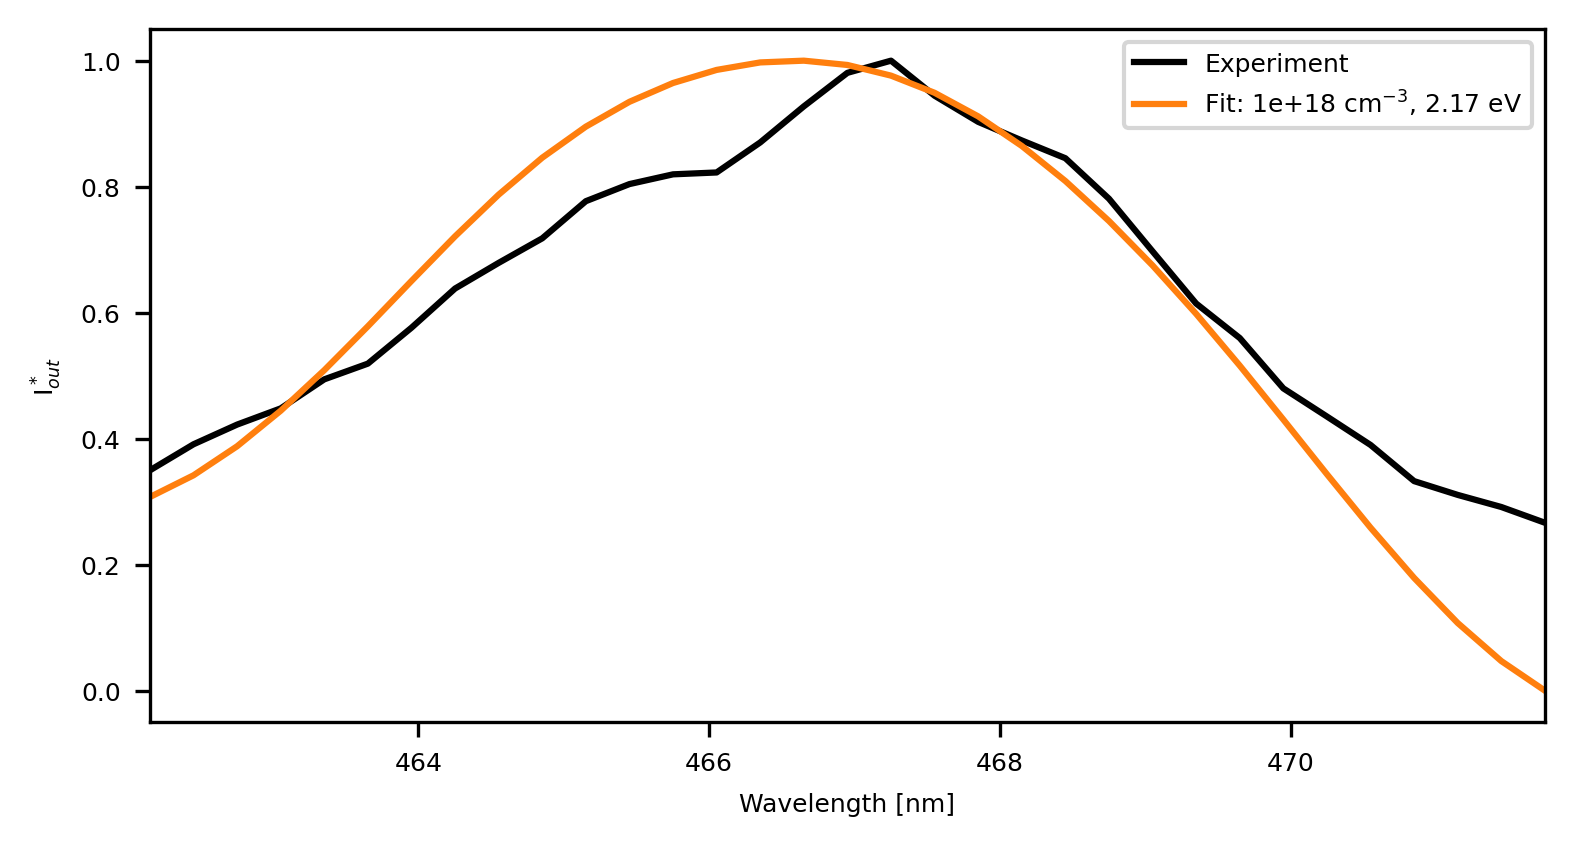

In [17]:
# First get density by fitting to Al-II 460 nm line

from scipy.optimize import curve_fit

# Isolated Al-II line for ni

E = np.load('./Data/E.npy')

def func(wl,n0,T0):
#     sig = getSigma(tid.iloc[num]*1e-9) # m
    sig = 0 # set to 0 for uniform density
    smax = 36e-3 # m, array height 
    I =  rt.simulate(n0,sig,T0,E,smax,wl,fwhm=1.625) # Intensity, W/m2/sr/eV
    return I / I.max()

idx = np.argwhere((wlnew >= 462) & (wlnew <=472)) # fit the interstage ALIII and AlII peaks
x = np.squeeze(wlnew[idx])
y = np.squeeze(np.roll(Inew,int(2/0.3))[idx])
y = y / y.max()

popt, pcov = curve_fit(func, x, y, sigma=0.09*np.ones(y.shape), bounds=([1e17,1.5], [1e18,2.5]),absolute_sigma=True)
# 9% error is determined from averaging the exp. spectra, see SVS5_marz1.mlx

# Plot
fig,axs=plt.subplots(1,1,figsize=(6,3),dpi=300)
axs.plot(x,y,label='Experiment',color='k')
axs.plot(x,func(x, *popt),label='Fit: %1.1g cm$^{-3}$, %1.2f eV' % tuple(popt),color='tab:orange')



axs.set_xlabel('Wavelength [nm]')
axs.set_ylabel('I$_{out}^*$')
axs.legend()
axs.set_xlim([x.min(),x.max()])
plt.show()

ni_AL2, T_AL2 = popt[0], popt[1]


In [18]:
# Check fit error
# print(pcov)
print(np.sqrt(np.diag(pcov)))

print('Error in ni [p.c.] = %1.2f'%(np.sqrt(np.diag(pcov))[0]/ni_AL2*100))

[1.09619177e-19 1.21533016e-01]
Error in ni [p.c.] = 0.00


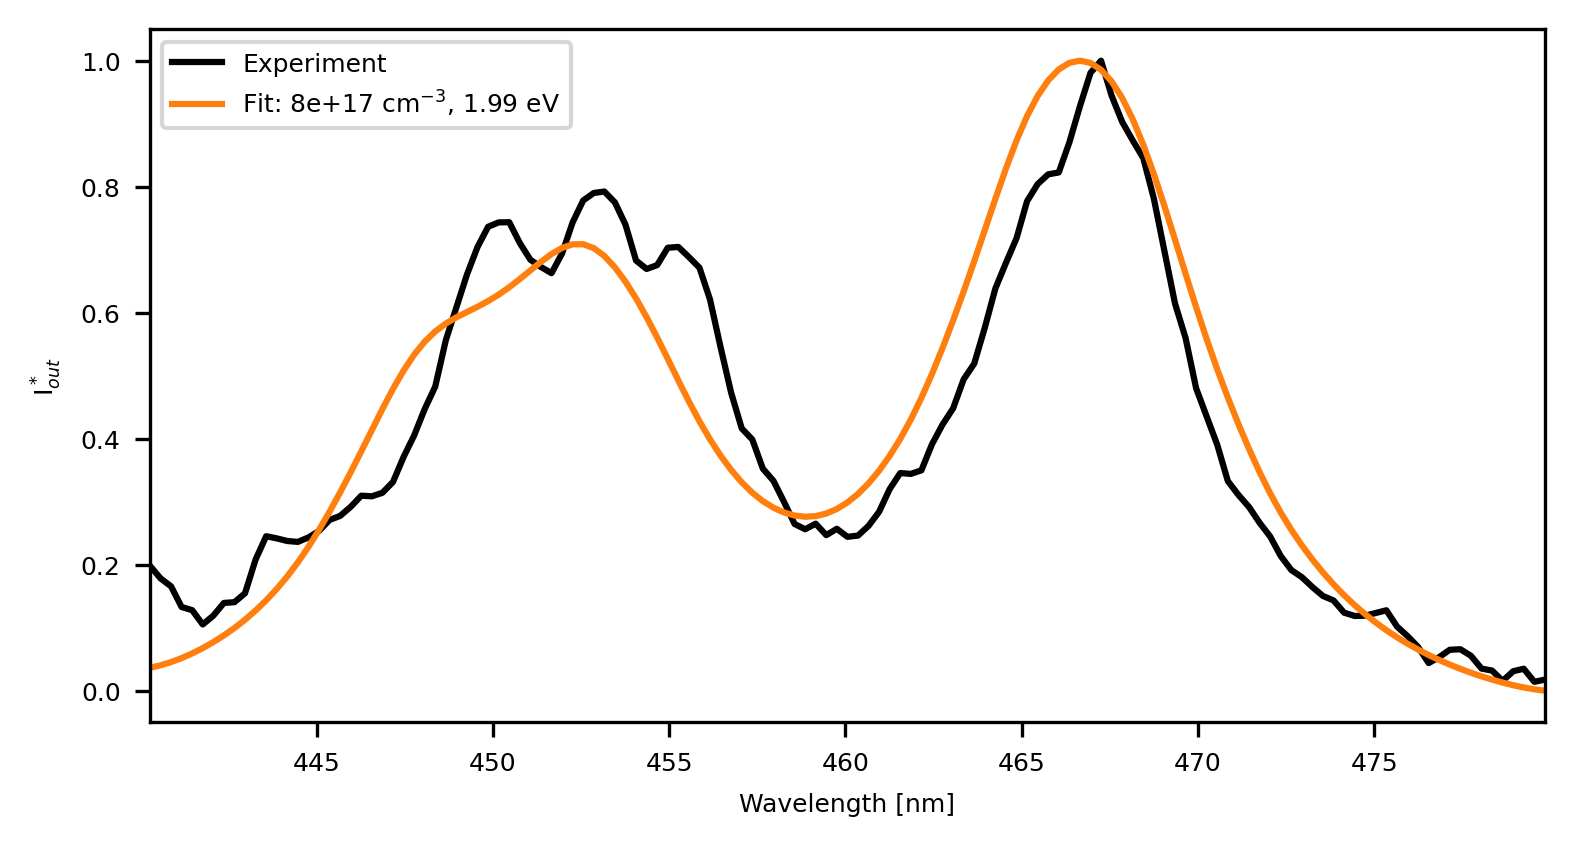

In [19]:
from scipy.optimize import curve_fit

# Now fit Interstage lines to get temperature

E = np.load('./Data/E.npy')

def func(wl,n0,T0):
    sig = 0 # set to 0 for uniform density
    smax = 36e-3 # m, array height 
    I =  rt.simulate(n0,sig,T0,E,smax,wl,fwhm=1.625)
    return I / I.max()

idx = np.argwhere((wlnew >= 440) & (wlnew <=480)) # fit the ALIII and AlII peaks
x = np.squeeze(wlnew[idx])
y = np.squeeze(np.roll(Inew,int(2/0.3))[idx])
y = y / y.max()

# Adjust the bounds based on density estimate
popt, pcov = curve_fit(func, x, y, sigma=0.09*np.ones(y.shape),bounds=([8e17,1.5], [10e17,2.4]),absolute_sigma=True)
# 9% error is determined from averaging the exp. spectra, see SVS5_marz1.mlx

# Plot
fig,axs=plt.subplots(1,1,figsize=(6,3),dpi=300)
axs.plot(x,y,label='Experiment',color='k')
axs.plot(x,func(x, *popt),label='Fit: %1.1g cm$^{-3}$, %1.2f eV' % tuple(popt),color='tab:orange')

# axs.set_title('t = %1.0d, $\sigma$ = %1.1f mm'%(tid.iloc[num],1e3*getSigma(tid.iloc[num]*1e-9)))

axs.set_xlabel('Wavelength [nm]')
axs.set_ylabel('I$_{out}^*$')
axs.legend()
axs.set_xlim([x.min(),x.max()])
plt.show()

ni_interstage, T_interstage = popt[0], popt[1]


In [20]:
# Check fit error
# print(pcov)
print(np.sqrt(np.diag(pcov)))
print('Error in Te [p.c.] = %1.2f'%(np.sqrt(np.diag(pcov))[1]/T_interstage*100))

[1.23961644e-20 2.18140137e-02]
Error in Te [p.c.] = 1.10


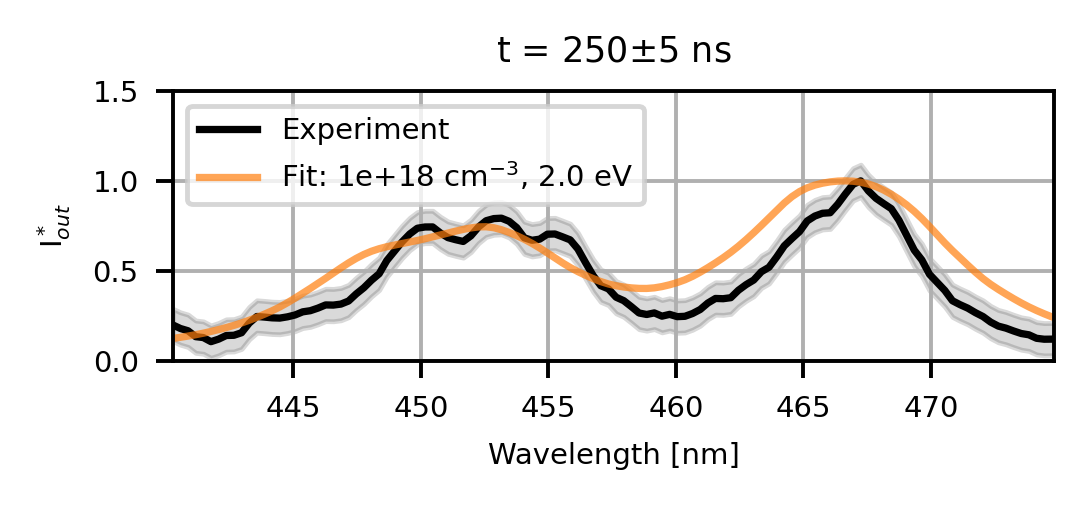

In [23]:
# Plot the result
fig,axs=plt.subplots(1,1,figsize=(6.5/2,1),dpi=350)
# y = np.squeeze(np.roll(Inew,int(0/0.3))[idx])
axs.plot(x,y,label='Experiment',color='k')
axs.fill_between(x,y-0.09,y+0.09,color='k',alpha=0.15) # 9% error is determined from averaging, see SVS5_marz1.mlx

n0 = 1e18
T0 = 1.99
sig = 0
L = 36e-3

Iout = rt.simulate(n0,sig,T0,E,L,wl,fwhm=1)
Iout = Iout[idx]
Iout = Iout / Iout.max()
# shift = 2
# Iout = np.roll(Iout,int(-shift/0.3))
# Iout[int(-shift/0.3):] = 0
axs.plot(x,Iout,label='Fit: %1.1g cm$^{-3}$, %1.1f eV' % tuple([n0,T0]),color='tab:orange',alpha=0.7)

axs.set_xlabel('Wavelength [nm]')
axs.set_ylabel('I$_{out}^*$')
axs.set_ylim([0,1.5])
axs.legend()
axs.set_xlim([x.min(),x.max()-5])
axs.grid()
axs.set_title('t = ' + str(tid.iloc[num]) + '$\pm$' + str(delt.iloc[num]) + ' ns')
plt.show()

saveDir = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/SVS/z3978/svs5/'
fname = 'z3978_svs5_' + str(tid.iloc[num])
dic = {}
dic['tid'] = tid.iloc[num]
dic['sig'] = sig
dic['n0'] = n0
dic['T0'] =  T0

import pickle
with open(saveDir + fname + '.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
fig.savefig(saveDir + fname + '.png',bbox_inches='tight')

savePath = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/Figures_POP/'

# fig.savefig(savePath + fname + '.png',bbox_inches='tight')

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

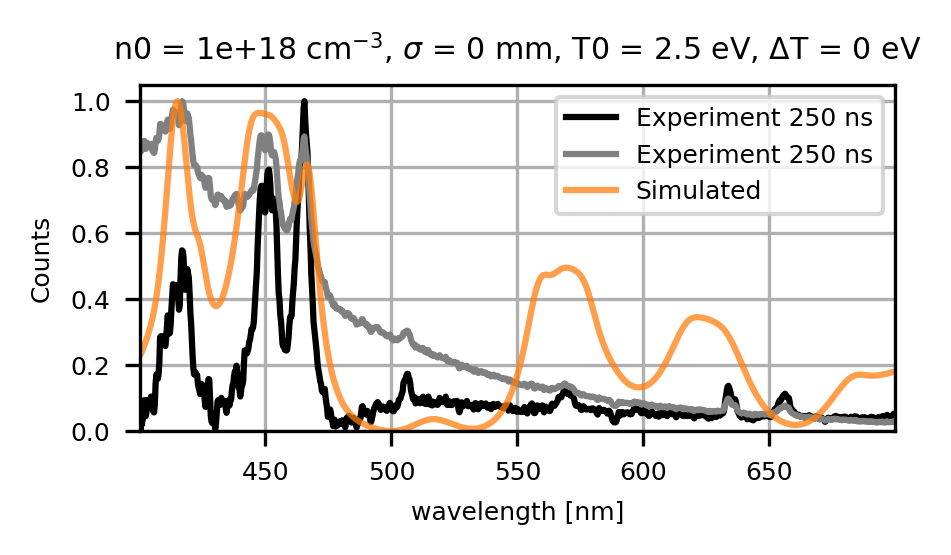

In [24]:
# Full spectrum fit

n0 = 1.0e18
sig = 0
smax = 36e-3
delT = 0
T0 = 2.5
E = np.load('./Data/E.npy')


Iout = rt.simulate(n0,sig,T0,E,smax,wlnew,fwhm=1.625)

# Plot
fig,axs=plt.subplots(1,1,figsize=(6.5/2,1.5),dpi=300)
axs.plot(wlnew,Inew,label='Experiment %3.0f ns' % (tid.iloc[num]),color='k')
axs.plot(wl,Iexp/Iexp.max(),label='Experiment %3.0f ns' % (tid.iloc[num]),color='grey')
axs.plot(wlnew,Iout/Iout.max(),label='Simulated',color='tab:orange',alpha=0.75)

axs.set_xlabel('Wavelength [nm]')
axs.set_ylabel('I$_{out}^*$')
axs.set_title('n0 = %1.3g cm$^{-3}$, $\sigma$ = %1.2g mm, T0 = %1.3g eV, $\Delta$T = %1.2g eV' % (n0,sig*1e3,T0,delT))
axs.legend()
axs.set_xlim([wlnew.min(),wlnew.max()])
axs.set_xlabel('wavelength [nm]')
axs.set_ylim(ymin=0)
axs.set_ylabel('Counts')
axs.grid()
plt.show()